In [23]:
%load_ext autoreload
%autoreload 2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append('../src')

from graph_utils import *
from performance_utils import *
from metropolis import *
from houdayer_algorithm import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
# Define the parameters
N = 100     # number of nodes
d = 5       # degree
r = 0.1     # b /a

a = (2. * d) / (1. + r)
b = a * r

print(f'd = {d}')
print(f'r = {r:.4f}')
print(f'r_c = {(np.sqrt(d)-1)/(np.sqrt(d)+1):.4f}')
print(f'a = {a:.4f}')
print(f'b = {b:.4f}')

d = 5
r = 0.1000
r_c = 0.3820
a = 9.0909
b = 0.9091


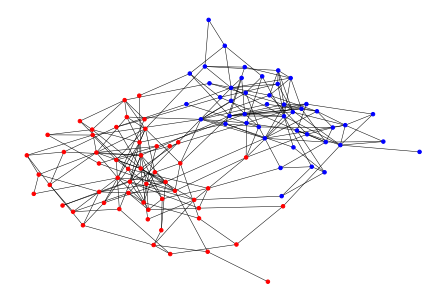

In [162]:
# Initialize random seed
#np.random.seed(0)

# Generate random state
x_star = generate_population(N)
G = graph_gen(x_star, a, b)
A = nx.to_numpy_array(G)

draw_graph(G, x_star)

# Simulations

In [163]:
nexp = 100   # Number of experiments
T = 1000     # Number of steps

## Metropolis

In [164]:
def run_metropolis(A, a, b, num_exp, T):
    Q = np.empty((num_exp, T))
    mc = Metropolis(A, a, b)
    for n in tqdm(range(num_exp)):
        mc.reset()
        for i in range(T):
            mc.step()
            Q[n, i] = compute_overlap(x_star, mc.x)
    return Q

In [165]:
Q = run_metropolis(A, a, b, nexp, T)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.58it/s]


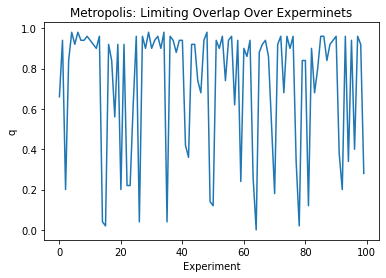

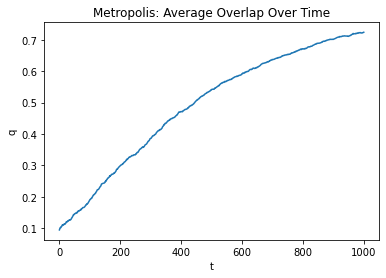

In [166]:
# Plots
plt.figure()
plt.plot(Q[:,-1])
plt.xlabel('Experiment')
plt.ylabel('q')
plt.title('Metropolis: Limiting Overlap Over Experminets');

plt.figure()
plt.plot(np.average(Q, axis=0))
plt.xlabel('t')
plt.ylabel('q')
plt.title('Metropolis: Average Overlap Over Time');

## Houdayer-1 

In [182]:
def run_houdayer(A, a, b, num_exp, T, num_met):
    Q1 = np.empty((num_exp, T))
    Q2 = np.empty((num_exp, T))
    mc1 = Metropolis(A, a, b)
    mc2 = Metropolis(A, a, b)
    for n in tqdm(range(num_exp)):
        mc1.reset()
        mc2.reset()
        for i in range(T):
            # Houdayer step
            x1, x2 = houdayer_step(G, mc1.x, mc2.x)
            mc1.x = x1
            mc2.x = x2
            for j in range(num_met):
                mc1.step()
                mc2.step()
            Q1[n, i] = compute_overlap(x_star, mc1.x)
            Q2[n, i] = compute_overlap(x_star, mc2.x)
    return Q1, Q2

In [183]:
Q1, Q2 = run_houdayer(A, a, b, nexp, T, num_met=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]


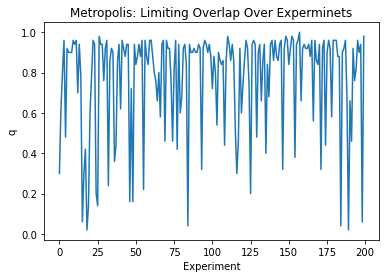

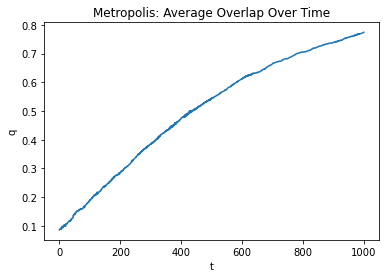

In [184]:
Q = np.vstack((Q1, Q2))

# Plots
plt.figure()
plt.plot(Q[:,-1])
plt.xlabel('Experiment')
plt.ylabel('q')
plt.title('Metropolis: Limiting Overlap Over Experminets');

plt.figure()
plt.plot(np.average(Q, axis=0))
plt.xlabel('t')
plt.ylabel('q')
plt.title('Metropolis: Average Overlap Over Time');